# Building an unstructured mesh

<div class="alert alert-block alert-info"> In this example, we use the ESRI Grid for Australia available from Geoscience Australia product catalogue (https://ecat.ga.gov.au/geonetwork/). You could download it when searching for Australian Bathymetry and Topography Grid, June 2009.  

We also provide in data folder a low resolution GeoTIFF that can also be used for this tutorial (AUS_LR.tiff). 


We will first _reproject the dataset_ in UTM coordinates, then we will use _shapefiles and countours_ to clipped on region of interested and then we will use </div>


We will create the following mesh:

***

<img src="images/australia.png" width="80%">

***



## Notebook contents

   - [Converting from lon/lat to metres](#Converting-from-lon/lat-to-metres)
   - [Clipped elevation grid](#Clipped-elevation-grid)
   - [X & Y axes](#X-&-Y-axes)
   - [Define contour lines](#Define-contour-lines)
   - [Unstructured elevation grid](#Unstructured-elevation-grid)
   - [Visualisation](#Visualisation)


In [1]:
import meshio
import numpy as np
from scipy.interpolate import RectBivariateSpline
import jigsawpy
import os
from collections import OrderedDict

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.path import Path
from mpl_toolkits.axes_grid1 import make_axes_locatable

label_size = 8
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

%matplotlib inline
%config InlineBackend.figure_format = 'svg' 

# Converting from lon/lat to metres

To reproject the grid from lon/lat coordinates to UTM (metres), two main libraries are available within the Docker image:

+ `pygeotools` -- https://github.com/dshean/pygeotools
+ `rasterio` -- https://github.com/mapbox/rasterio

First, we specify our DEM filename:

In [2]:
filename = 'input_data/AUS_LR.tiff'

Below, we show how this can be done using rasterio. First we load the required libraries and then define the requested projection (here we used EPSG reference for the region EPSG:28355).

In [3]:
import rasterio
from rasterio import crs
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio import drivers

# Reproject to EPSG zone
dst_crs = {'init': 'EPSG:28355'}

# Requested reprojected dataset resolution (metres)
utmRes = 10000.

We then use the following cell to make the projection and get the interpolated elevation points at the requested resolution (elev -- a numpy masked array)

(3700, 4500) int16


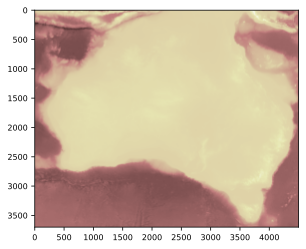

In [4]:
with rasterio.open(filename) as src:
    array = src.read(1)
    print(array.shape, array.dtype)
    
    plt.imshow(array, cmap='pink')

In [5]:
with rasterio.open(filename) as src:

    profile = src.profile
    print(profile)
    if src.nodata is None:
        nodata = -100000
    else:
        nodata = src.nodata

    if src.crs is None:
        src_crs = src_crs
    else:
        src_crs = src.crs

    # Calculate the ideal dimensions and transformation in the new crs
    dst_affine, dst_width, dst_height = calculate_default_transform(
        src_crs, dst_crs, src.width, src.height, *src.bounds, resolution=utmRes)

    # update the relevant parts of the profile
    profile.update({
        'crs': dst_crs,
        'transform': dst_affine,
        'width': dst_width,
        'height': dst_height,
    })

    # Reproject and write each band
    src_array = src.read()
    dst_array = np.empty((int(dst_height), int(dst_width)), dtype='float32')

    reproject(
            # Source parameters
            source=src_array,
            src_crs=src_crs,
            src_transform=src.transform,
            src_nodata=nodata,

            # Destination paramaters
            destination=dst_array,
            dst_transform=dst_affine,
            dst_crs=dst_crs,
            dst_nodata=nodata,

            # Configuration
            resampling=Resampling.nearest,
            num_threads=2)

    elev = np.ma.masked_where(dst_array == nodata, dst_array)

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32768.0, 'width': 4500, 'height': 3700, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.01, 0.0, 110.0,
       0.0, -0.01, -8.0), 'tiled': False, 'compress': 'deflate', 'interleave': 'band'}


We can look at the metadata associated with the new GeoTIFF file using for example:

In [6]:
profile

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32768.0, 'width': 527, 'height': 482, 'count': 1, 'crs': {'init': 'EPSG:28355'}, 'transform': Affine(10000.0, 0.0, -3881832.298041893,
       0.0, -10000.0, 9115700.951226361), 'tiled': False, 'compress': 'deflate', 'interleave': 'band'}

# Clipped elevation grid

We can visualise the new elevation array using the following function:

In [7]:
def plotElevation( data, cmin, cmax, colormap):
    '''
    data: dataset to plot
    zmin,zmax: extent of the colormap
    colormap: to use    
    '''
    
    # Figure size is defined here
    fig = plt.figure(1, figsize=(8,8))
    
    ax = plt.gca()
    im = ax.imshow(data, interpolation='nearest', cmap=colormap,
                     vmin=cmin, vmax=cmax)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.1)
    cbar = plt.colorbar(im,cax=cax)
    plt.tight_layout()

    plt.show()
    plt.close(fig)

We choose to use pycpt -- Python tools to load and handle cpt (GMT format) color maps for use with matplotlib (e.g. from cpt-city)
You can pick a colorbar from the following website:
    
- http://soliton.vm.bytemark.co.uk/pub/cpt-city/index.html

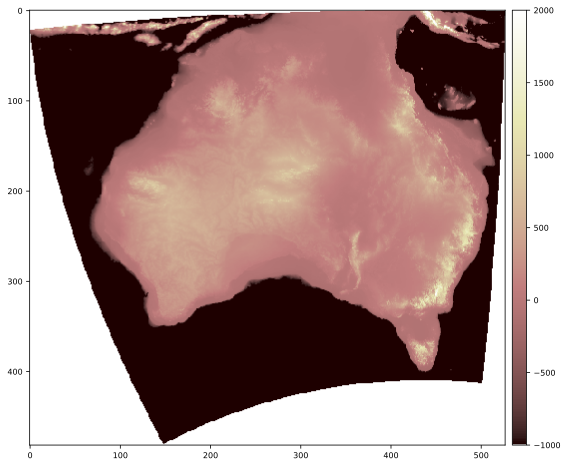

In [8]:
topocmap = 'pink'
plotElevation( elev, -1000, 2000, topocmap)

As you can see from the figure above, we will need to clip our array to remove the nodata values induced by the reprojection... We do that by just selecting the extent of the rows and columns number from our elev numpy array...

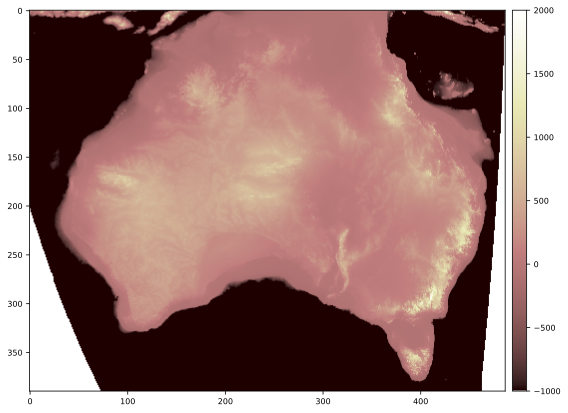

In [9]:
plotElevation( elev[20:410,40:], -1000, 2000, topocmap)

We then defined a new elevation array dem based on the clipped one:

In [10]:
#dem = elev[150:-150,150:-150]
dem = elev[20:410,40:]

# X & Y axes

To keep your coordinates system for post-processing and to potentially reproject the outputs from the landscape evolution model in another geospatial system we needs to specify the X and Y axes.
We do it like this

In [11]:
xMin = dst_affine[2]
xMax = dst_affine[2] + abs(dst_affine[0])*dst_width

yMin = dst_affine[5] - abs(dst_affine[4])*dst_height
yMax = dst_affine[5]

print("Initial DEM:\n")

print("Lower left coordinates       Xmin: {}, Ymin: {}".format(xMin,yMin))
print("Upper right coordinates      Xmax:  {}, Ymax: {}".format(xMax,yMax))

Initial DEM:

Lower left coordinates       Xmin: -3881832.298041893, Ymin: 4295700.951226361
Upper right coordinates      Xmax:  1388167.7019581068, Ymax: 9115700.951226361


We can now create the X and Y coordinates, at this point we can choose to decrease the resolution if needed by using the step parameter (integer)

In [12]:
step = 1
spacing = utmRes*step

Z = dem[::step,::step]

nx = Z.shape[1]
ny = Z.shape[0]

minX, maxX = xMin, xMin+spacing*nx
minY, maxY = yMin, yMin+spacing*ny

xcoords = np.arange(minX, maxX, spacing)
ycoords = np.arange(minY, maxY, spacing)

X, Y = np.meshgrid(xcoords, ycoords)

coords = np.vstack([X.ravel(), Y.ravel()])

print("Clipped DEM:\n")

print("Resolution (m)            res: {}".format(spacing))
print("Number of points         nbpt: {}".format(coords.shape[0]))
print("Elevation map shape        nx: {}, ny: {}\n".format(nx,ny))

print("Lower left coordinates   Xmin: {}, Ymin: {}".format(minX,minY))
print("Upper right coordinates  Xmax: {}, Ymax: {}".format(maxX,maxY))

Clipped DEM:

Resolution (m)            res: 10000.0
Number of points         nbpt: 2
Elevation map shape        nx: 487, ny: 390

Lower left coordinates   Xmin: -3881832.298041893, Ymin: 4295700.951226361
Upper right coordinates  Xmax: 988167.7019581068, Ymax: 8195700.951226361


# Define contour lines

From the projected digital elevation, we will extract contour lines at given depth and use these lines to define the extent of our simulation region and its resolution. 

First we define the `extractContours` function that returns the list of countour lines

In [13]:
def extractContours( X, Y, Z, cmin, cmax, colormap, ctrlist):
    '''
    coords: coordinate points (X,Y,X)
    cmin,cmax: extent of the colormap
    colormap: color scale to use
    ctrlist: list of contours to extract
    '''
    # Figure size is defined here
    fig = plt.figure(1, figsize=(8,8))
    ctrs = []
    for k in range(len(ctrlist)):
        print(k, len(ctrlist), ctrlist[k], type(ctrlist[k]))
        ctrs.append(plt.contour(X, Y, 
                    np.flipud(Z), [ctrlist[k]]))
    ax = plt.gca()
    im = ax.imshow(Z, interpolation='nearest', cmap=colormap,
                     vmin=cmin, vmax=cmax,extent=[minX, maxX,minY, maxY])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.1)
    cbar = plt.colorbar(im,cax=cax)
    plt.tight_layout()

    plt.show()
    plt.close(fig)

    return ctrs

Then we specify a list of contour line depths `ctrList` that needs to be defined in **ascending order** (this is important for what follows)

0 1 -12.0 <class 'float'>


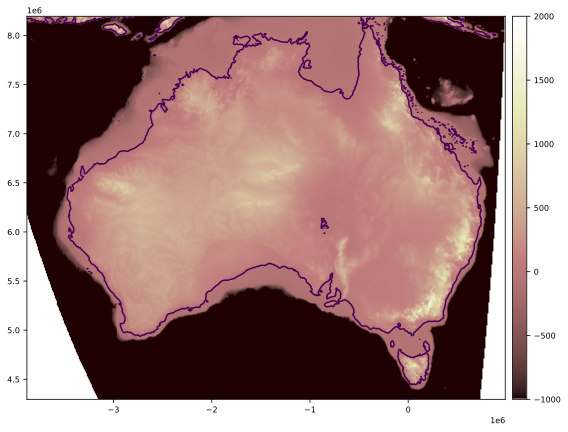

In [14]:
ctrList = [-12.,]

# Now we extract the contours lines using the previous function
if sorted(ctrList) == ctrList:
    ctrs = extractContours(X, Y, Z, -1000, 2000, topocmap, ctrList)
else:
    print("ERROR:")
    print("The list of contour positions needs to be specify in ascending order!")
    print("Redefine the ctrList variable")

In [15]:
print(ctrs)

We can see from the figure above that we have several contour lines for any single depth. We will only use the **longest lines for each depth** to define our simulation domain.

To do so we will define two functions:
+ `distancePts`: that will be used to get the euclidian distance between 2 points
+ `getLongestContoursXY`: that extract the longest lines and resample it based on a characteristic length `lcar`

In [16]:
def distancePts(p1,p2):
    '''
    Compute the euclidian distance between 2 points (p1, p2)
    
    '''
    return (p1[1]-p2[1])**2+(p1[0]-p2[0])**2 

In [17]:
def getLongestContoursXY(ctrs, lcar):
    '''
    1- Extract from the list of contour points the longest path
    2- Using a characteristic length (lcar) resample the path 
    3- Return the XY coordinates of the longest paths
    '''

    ctrPoints = []
    # Loop through the contour lines 
    for ct in range(len(ctrs)):
        cpath = []
        k = 0
        maxpts = 0
        pathID = 0
        
        # For each contour extract the longest path
        for collection in ctrs[ct].collections:
            for path in collection.get_paths():
                if len(path)>4:
                    cpath.append(np.asarray(path.to_polygons()[0]))
                    # Storing longest path
                    if cpath[-1].shape[0] > maxpts:
                        maxpts =  cpath[-1].shape[0]
                        pathID = k
                    k += 1

        # Find longest path XY coordinates 
        Cpts = cpath[pathID]
        x = Cpts[:,0]
        y = Cpts[:,1]
        tmp = OrderedDict()
        for pt in zip(x,y):
            tmp.setdefault(pt[:1], pt)   
        ctrPts = np.asarray(list(tmp.values()))
        # Resample the path to the requested characteristic length
        ki = 0
        tmpPts = []
        cumdist = 0.
        tmpPts.append(ctrPts[0,:])
        for k in range(1,ctrPts.shape[0]):
            cumdist = distancePts(ctrPts[ki,:2], ctrPts[k,:2])
            if(cumdist >= lcar):
                tmpPts.append(ctrPts[k,:])
                ki = k
        ctrPoints.append(np.asarray(tmpPts))

    return ctrPoints

The `getLongestContoursXY` function will return the longest line resampled points coordinates for each contour depths defined in `ctrList`

In [18]:
ctrPoints = getLongestContoursXY(ctrs,1.)

Let's plot the picked contour lines...

In [19]:
def plotContours( X, Y, Z, cmin, cmax, colormap, ctrPts):
    '''
    coords: coordinate points (X,Y)
    zmin,zmax: extent of the colormap
    colormap: to use  
    ctrPts: coordinates of contour lines
    '''
    # Figure size is defined here
    fig = plt.figure(1, figsize=(8,8))
    ctrs = []
    for k in range(len(ctrPts)):
        plt.scatter(ctrPts[k][:,0], ctrPts[k][:,1], s=0.3, c='k')
    ax = plt.gca()
    im = ax.imshow(Z, interpolation='nearest', cmap=colormap,
                     vmin=cmin, vmax=cmax,extent=[minX, maxX,minY, maxY])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.1)
    cbar = plt.colorbar(im,cax=cax)
    plt.tight_layout()

    plt.show()
    plt.close(fig)

    return 

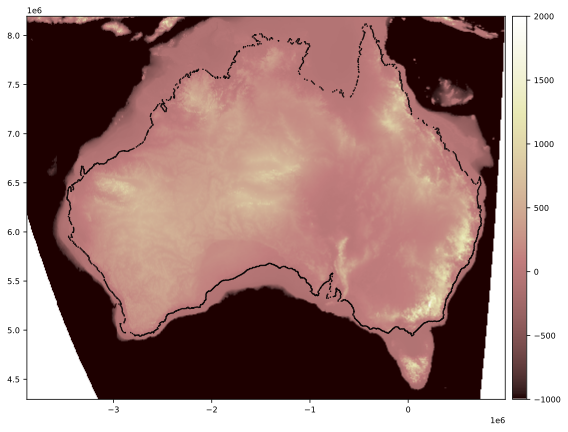

In [20]:
plotContours(X, Y, Z, -1000, 2000, topocmap, ctrPoints)

In [21]:


dst_path = "output_data"

opts = jigsawpy.jigsaw_jig_t()
geom = jigsawpy.jigsaw_msh_t()
mesh = jigsawpy.jigsaw_msh_t()
# refinement function mesh
hfun = jigsawpy.jigsaw_msh_t()

opts.geom_file = os.path.join(dst_path, "pslg.msh")
opts.jcfg_file = os.path.join(dst_path, "pslg.jig")
opts.mesh_file = os.path.join(dst_path, "mesh.msh")
opts.hfun_file = os.path.join(dst_path, "spac.msh")

output_vtk = os.path.join(dst_path, "AUS_LR.vtk")

#######################################
# Setup contour points as a big polygon
geom.mshID = "euclidean-mesh"
geom.ndims = +2

# For each point in the contour, add it as a vertex
arr = []
for i in range(ctrPoints[0].shape[0]):
    arr.append(([ctrPoints[0][i][0], ctrPoints[0][i][1]], 0))
    
arr = np.array(arr, dtype=geom.VERT2_t)
geom.vert2 = arr

# Now link each vertex with a line, remembering to link the first
# and last points too.
lineLoop=[]
for i in range(ctrPoints[0].shape[0]):
    if i < ctrPoints[0].shape[0]-1:
        lineLoop.append(([i, i+1], 0))
    else:
        lineLoop.append(([i, 0], 0))
edges = np.array(lineLoop, dtype=geom.EDGE2_t)
geom.edge2 = edges

jigsawpy.savemsh(opts.geom_file, geom)
#
#######################################

#######################################
# Mesh refinement
hfun.mshID = "euclidean-grid"
hfun.ndims = +2

hfun.xgrid = xcoords
hfun.ygrid = ycoords

# min and max mesh sizes
hmin = 10000
hmax = 100000


out = np.flipud(Z).astype(dtype=jigsawpy.jigsaw_msh_t.REALS_t, copy=True)
# Take the magnitude of the gradient of the topo, 
grad = np.linalg.norm(np.gradient(out), axis=0)
# Shift the gradient to be all >= 0
grad += np.min(grad)
# Take the squareroot (or whatever) to reduce the variance of the gradient
scaled = np.power(grad, 0.25)

# Set the gradient to be 0 in areas we don't care about
land_mask = np.flipud(Z) < -30
scaled[land_mask] = 0

# Flip the sign of the gradient field, so areas with high gradient have small numbers
# (corresponding with small mesh size)
scaled = np.max(scaled) - scaled
# Now scale the gradient to fit between the min and max size for the mesh
scaled = ((scaled - np.min(scaled)) / (np.max(scaled) - np.min(scaled))) * (hmax - hmin) + hmin

hfun.value = scaled

# Not really sure what this does
hfun.slope = np.full(
        hfun.value.shape, +0.1500,
        dtype=jigsawpy.jigsaw_msh_t.REALS_t)

jigsawpy.savemsh(opts.hfun_file, hfun)

# Apply the refinement
jigsawpy.cmd.marche(opts, hfun)

#
#######################################

opts.hfun_scal = "absolute"
opts.hfun_hmax = float("inf")

opts.mesh_dims = +2                 # 2-dim. simplexes

#opts.geom_feat = True               # do sharp feature
#opts.mesh_top1 = True               # preserve 1-topo.

opts.mesh_eps1 = +1.0E+00           # relax edge error

opts.optm_qlim = +9.5E-01           # tighter opt. tol
opts.optm_iter = +32
opts.optm_qtol = +1.0E-05

jigsawpy.cmd.jigsaw(opts, mesh)

zfun = RectBivariateSpline(xcoords,ycoords,np.flipud(Z).T)
mesh.value = zfun(mesh.point['coord'][:,0], mesh.point['coord'][:,1], grid=False)

#------------------------------------ save mesh for Paraview

mesh = meshio.Mesh(mesh.point['coord'], {'triangle': mesh.tria3['index']}, {'Z':mesh.value})
meshio.write(output_vtk, mesh)




10000.0 100000.0


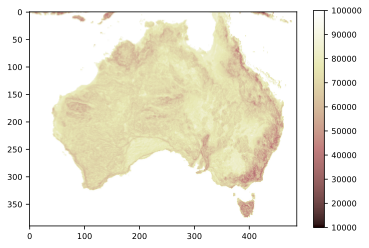

In [22]:
plt.imshow(np.flipud(scaled), cmap='pink')
plt.colorbar()
print(np.min(hfun.value), np.max(hfun.value))